In [ ]:
# Import needed library
from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout, Reshape, Flatten
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# Read in the Gold dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv", index_col='Date')

FileNotFoundError: ignored


# Preprocessing Data

---

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

In [ ]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# Split dataset (7-2-1)

---



In [ ]:
# 4. Split data
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Function create Dataset
import numpy
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
from keras.layers import Layer
from keras import backend as K

# Attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='normal')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros')        
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

model.add(Attention())

# Add a Reshape layer to convert the output shape to (None, 64)
model.add(Reshape((-1, 64)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

model.add(Attention())
# Add a dropout layer with a rate of 0.5
# model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
# model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(X_train, y_train, validation_data=(X_test,ytest),epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
# model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
# model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
# model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
# model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
# model.add(Dense(1))

# Build the model
model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=len(y_train), output_dim=50, input_length=10))

# Add an LSTM layer
model.add(LSTM(units=64, return_sequences=True))

# Add an Attention layer
model.add(Attention())

# Add a Dense layer
model.add(Dense(units=32, activation='relu'))

# Add the output layer
model.add(Dense(units=5, activation='softmax'))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(X_train, y_train, validation_data=(X_test,ytest),epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
# Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
# Predict test and validate
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 27ms/step


In [ ]:
# Normalize the data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)
  
  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
print(x_input.shape)

(1, 70, 1)


In [ ]:
# Predict the next 30 days
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=70
i=0
while(i<30):
    
    if(len(temp_input)>70):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


AttributeError: ignored

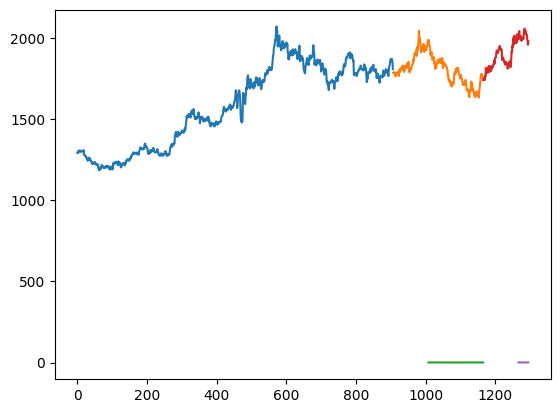

In [ ]:
# Plot the predict
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("Gold Price Prediction")
plt.show()

In [ ]:
evaluateModel(ytest,y_pred,yval,y_pred_val)

# Split dataset (6-3-1)

---



In [ ]:
# 4. Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(X_train, y_train, validation_data=(X_test,ytest),epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.19720, saving model to save_model_7-3.hdf5
14/14 - 13s - loss: 0.1972 - val_loss: 0.0674 - 13s/epoch - 921ms/step
Epoch 2/80

Epoch 2: loss improved from 0.19720 to 0.07845, saving model to save_model_7-3.hdf5
14/14 - 4s - loss: 0.0784 - val_loss: 0.0788 - 4s/epoch - 268ms/step
Epoch 3/80

Epoch 3: loss improved from 0.07845 to 0.05953, saving model to save_model_7-3.hdf5
14/14 - 4s - loss: 0.0595 - val_loss: 0.0643 - 4s/epoch - 266ms/step
Epoch 4/80

Epoch 4: loss improved from 0.05953 to 0.05528, saving model to save_model_7-3.hdf5
14/14 - 5s - loss: 0.0553 - val_loss: 0.0722 - 5s/epoch - 352ms/step
Epoch 5/80

Epoch 5: loss improved from 0.05528 to 0.05117, saving model to save_model_7-3.hdf5
14/14 - 3s - loss: 0.0512 - val_loss: 0.0527 - 3s/epoch - 243ms/step
Epoch 6/80

Epoch 6: loss improved from 0.05117 to 0.04701, saving model to save_model_7-3.hdf5
14/14 - 3s - loss: 0.0470 - val_loss: 0.0529 - 3s/epoch - 230ms/step
Epoch 7/80



In [ ]:
# Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 3s 288ms/step - loss: 0.0280 - val_loss: 0.0308
Epoch 2/100
11/11 [==============================] - 3s 308ms/step - loss: 0.0272 - val_loss: 0.0284
Epoch 3/100
11/11 [==============================] - 3s 268ms/step - loss: 0.0285 - val_loss: 0.0281
Epoch 4/100
11/11 [==============================] - 4s 414ms/step - loss: 0.0288 - val_loss: 0.0318
Epoch 5/100
11/11 [==============================] - 3s 303ms/step - loss: 0.0295 - val_loss: 0.0491
Epoch 6/100
11/11 [==============================] - 3s 318ms/step - loss: 0.0310 - val_loss: 0.0361
Epoch 7/100
11/11 [==============================] - 3s 282ms/step - loss: 0.0312 - val_loss: 0.0285
Epoch 8/100
11/11 [==============================] - 4s 371ms/step - loss: 0.0292 - val_loss: 0.0285
Epoch 9/100
11/11 [==============================] - 4s 373ms/step - loss: 0.0292 - val_loss: 0.0290
Epoch 10/100
11/11 [==============================] - 3s 299ms/step - loss: 0.0274 - val_lo

In [ ]:
# Predict test and validate
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [ ]:
# Normalize the data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# Predict the next 30 days
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=70
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


In [ ]:
# Plot the predict
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("Gold Price Prediction")
plt.show()

In [ ]:
evaluateModel(ytest,y_pred,yval,y_pred_val)

# Split dataset (5-3-2)

---



In [ ]:
# 4. Split data
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7-3.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(X_train, y_train, validation_data=(X_test,ytest),epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
# Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
# Predict test and validate
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [ ]:
# Normalize the data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# Predict the next 30 days
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=70
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


In [ ]:
# Plot the predict
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("Gold Price Prediction")
plt.show()

In [ ]:
evaluateModel(ytest,y_pred,yval,y_pred_val)

# Evaluate Model

---

